Epoch 1 | Loss_D: 0.3484 | Loss_G: 2.8383


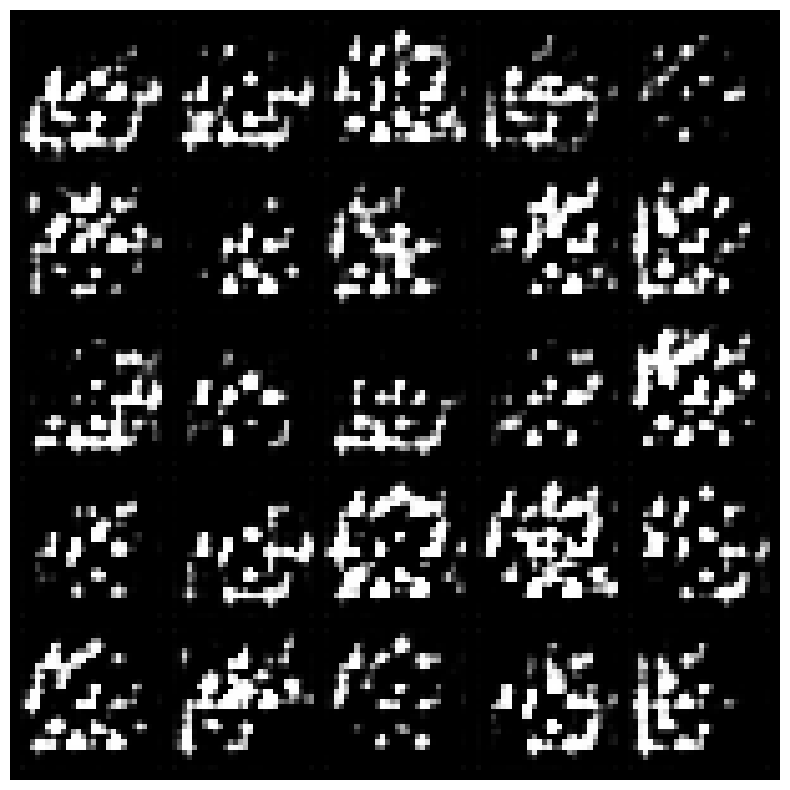

Epoch 2 | Loss_D: 0.3317 | Loss_G: 1.7346


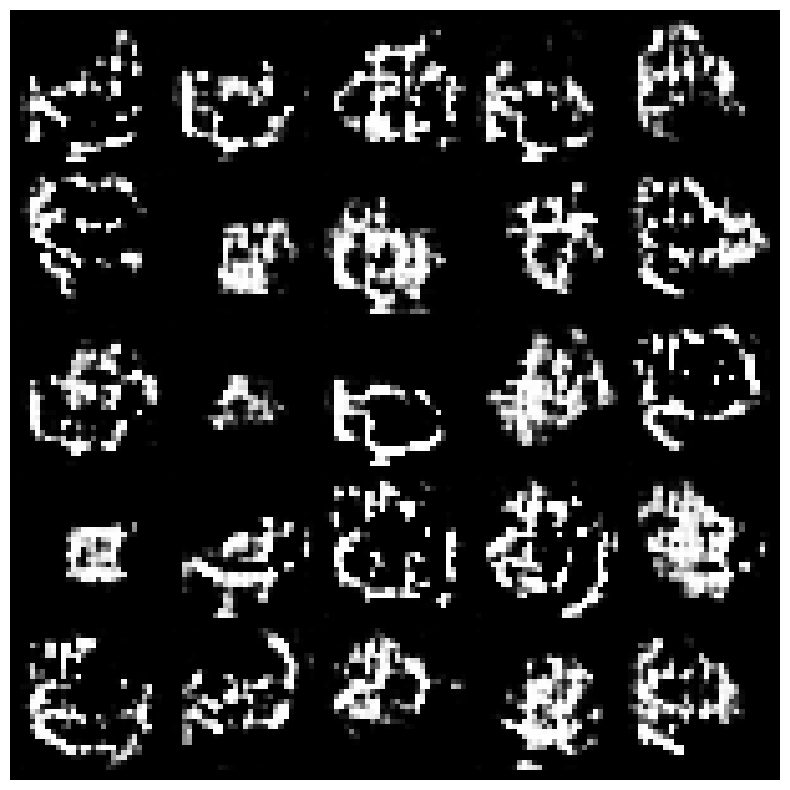

Epoch 3 | Loss_D: 0.3699 | Loss_G: 4.8324


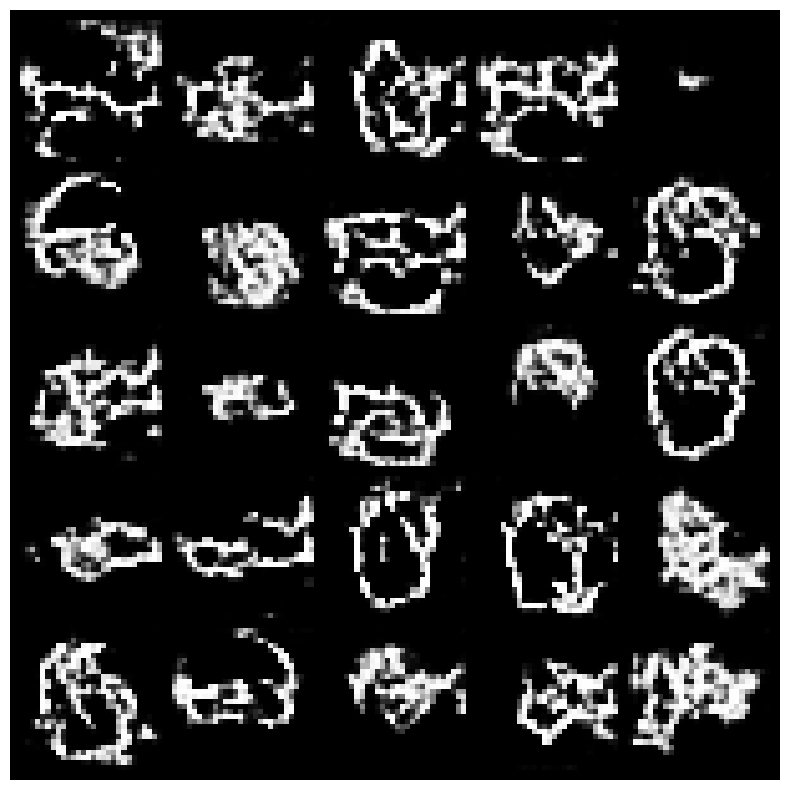

Epoch 4 | Loss_D: 0.4753 | Loss_G: 4.8103


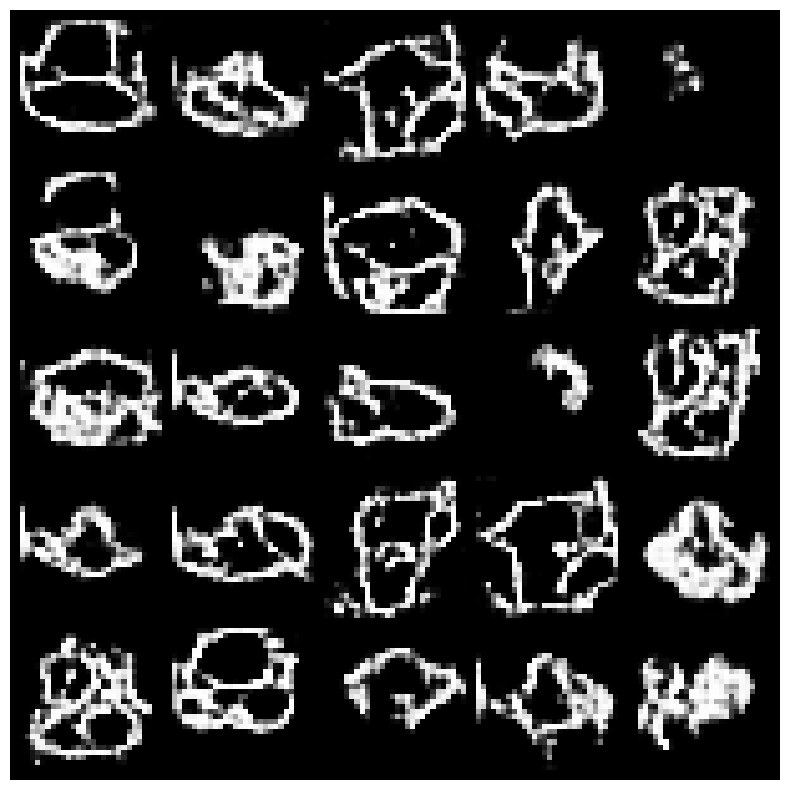

Epoch 5 | Loss_D: 0.1904 | Loss_G: 2.1539


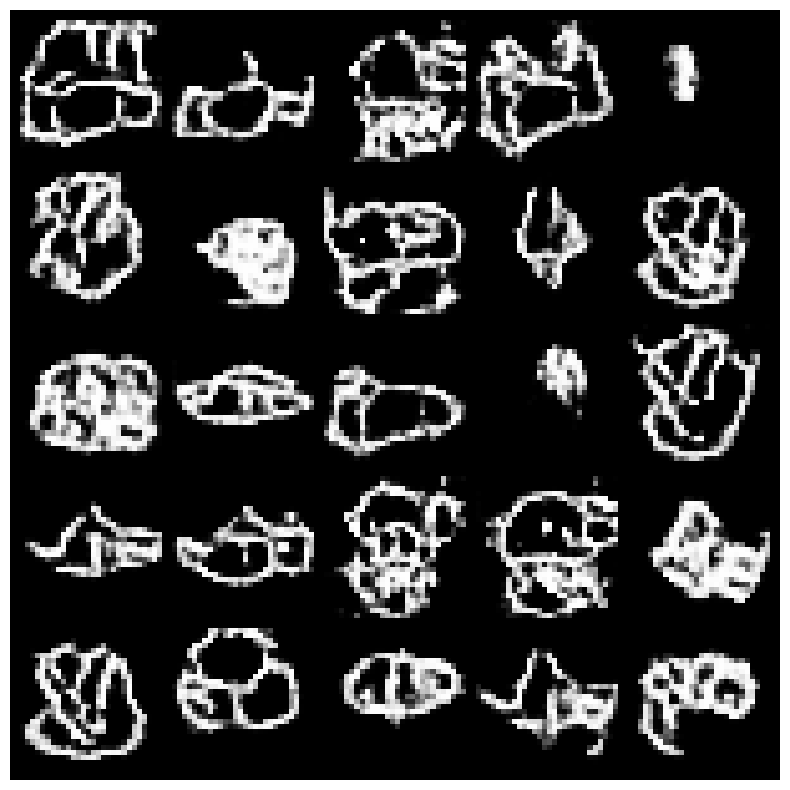

Epoch 6 | Loss_D: 0.1765 | Loss_G: 2.3879


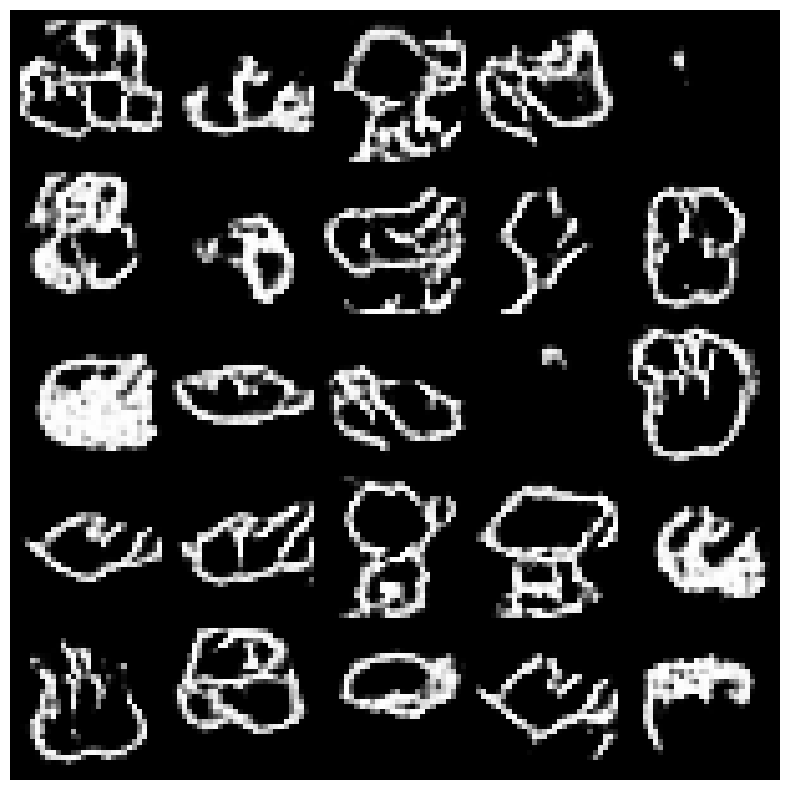

Epoch 7 | Loss_D: 0.1247 | Loss_G: 2.7602


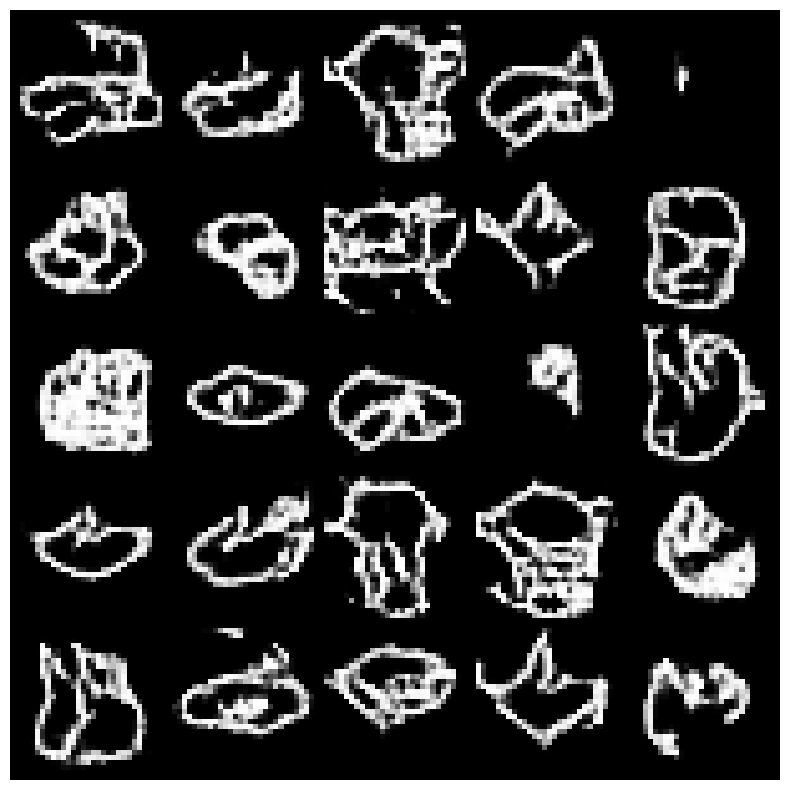

Epoch 8 | Loss_D: 0.0978 | Loss_G: 3.0661


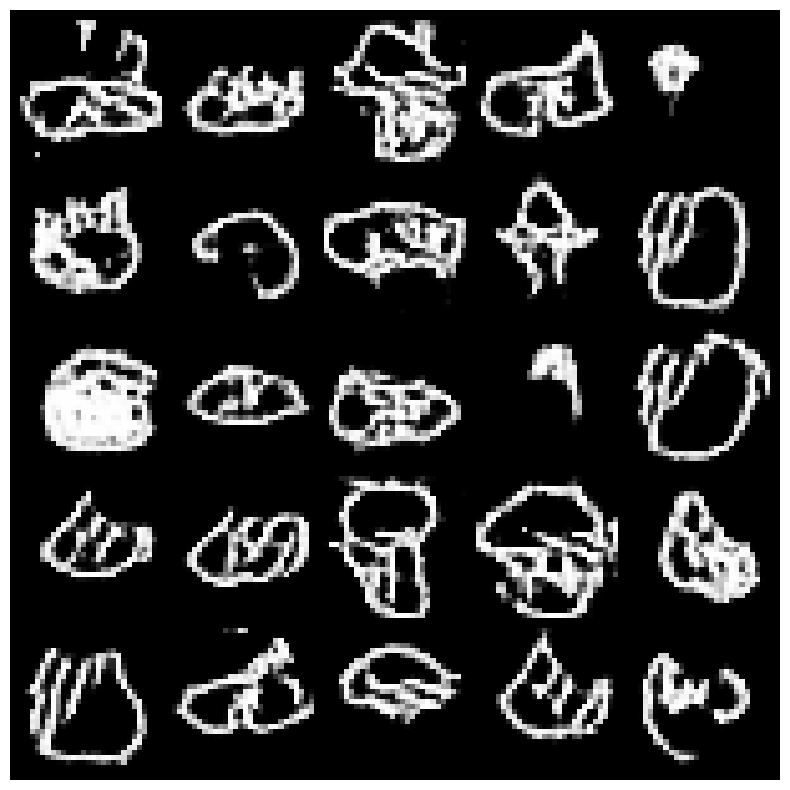

Epoch 9 | Loss_D: 0.0966 | Loss_G: 2.5737


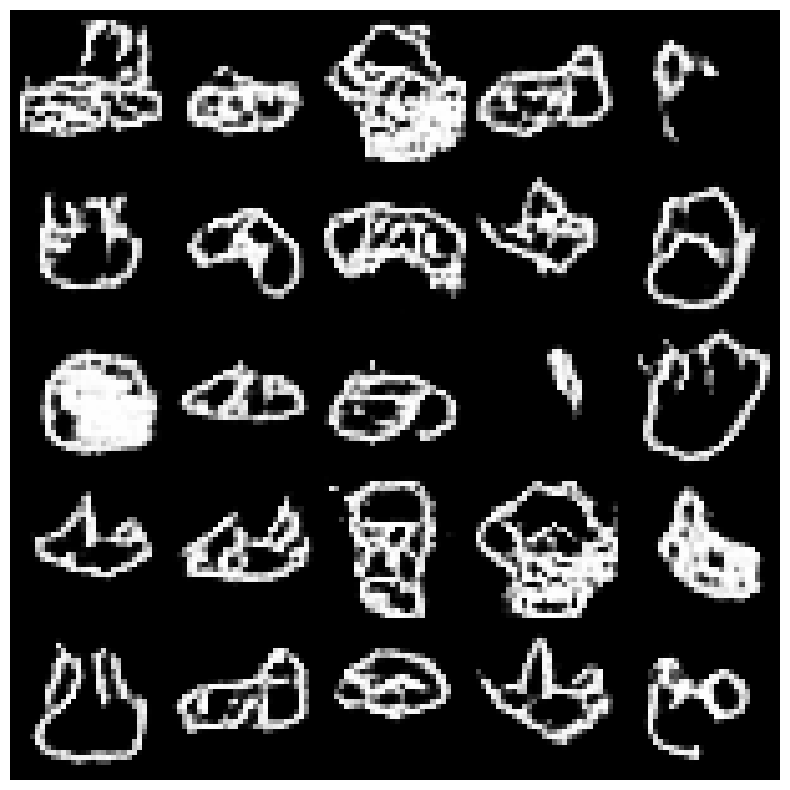

Epoch 10 | Loss_D: 0.0954 | Loss_G: 2.9619


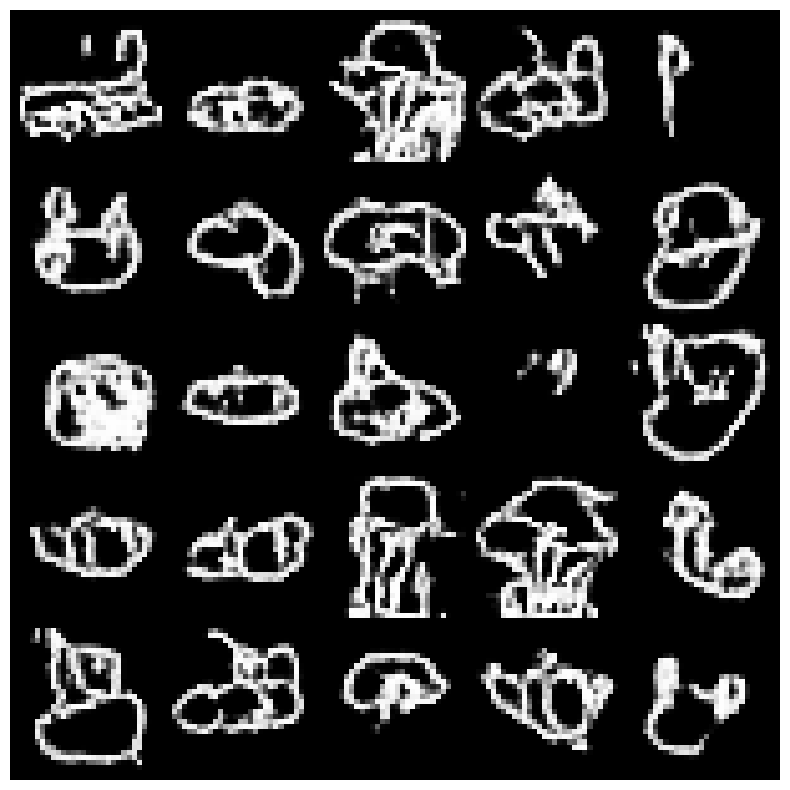

Epoch 11 | Loss_D: 0.0849 | Loss_G: 3.9355


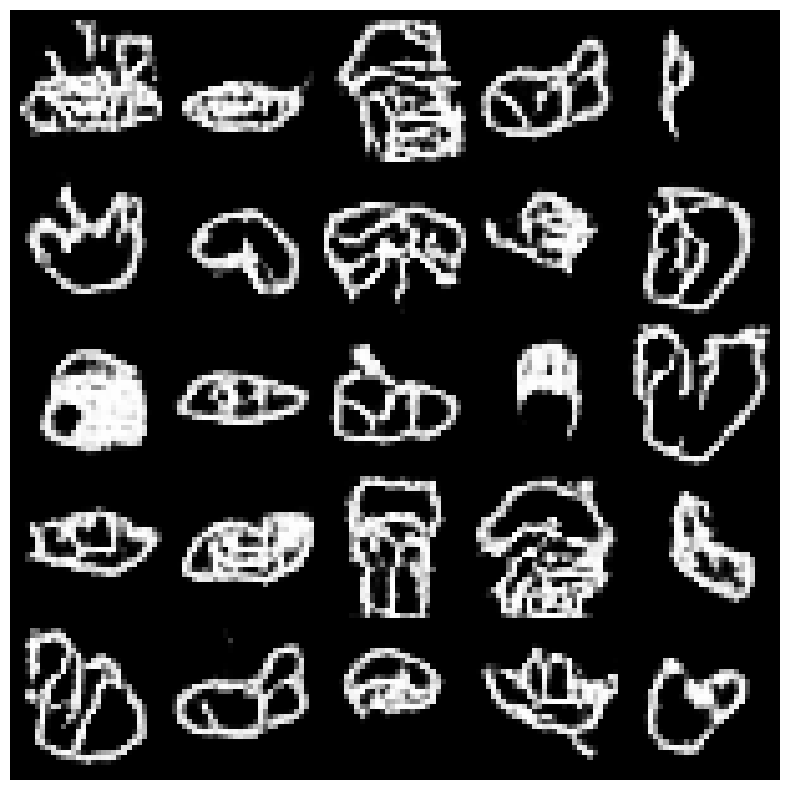

KeyboardInterrupt: 

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as v2
import numpy as np
import matplotlib.pyplot as plt

# GAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                1, features_d, kernel_size=4, stride=2, padding=1
            ), # 14 x 14
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # 7 x 7
            self._block(features_d*2, features_d*4, 3, 2, 0), # 3 x 3
            nn.Conv2d(features_d*4, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid()
        )


    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False # not needed because of batch norm
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, img):
        return self.disc(img)

# GAN Generator
class Generator(nn.Module):
    def __init__(self, z_dim, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g*8, 3, 1, 0), # 3 x 3
            self._block(features_g*8, features_g*4, 5, 2, 1), # 7 x 7
            self._block(features_g*4, features_g*2, 4, 2, 1), # 14 x 14
            nn.ConvTranspose2d(features_g*2, 1, kernel_size=4, stride=2, padding=1), # 28 x 28
            nn.Tanh() # [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False # not needed because of batch norm
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, noise):
        return self.gen(noise)

def weights_init_normal(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def sample_gan_images(generator, noise, epoch):
    with torch.no_grad():
        generated_images = generator(noise) 
        generated_images = generated_images.cpu() * 0.5 + 0.5  # Unnormalize from [-1, 1] to [0, 1]

    grid_img = vutils.make_grid(generated_images, nrow=5, padding=2, normalize=False)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))  # CHW -> HWC for plt
    plt.axis('off')
    plt.show()

    # Plot
    #_, axs = plt.subplots(5, 5, figsize=(10, 10))
    #for i, ax in enumerate(axs.flatten()):
        #img = generated_images[i, 0].cpu()

        #ax.imshow(img, cmap='gray')
        #ax.axis('off')
        
    #plt.suptitle(f'Sampled Images at Epoch {epoch}')
    #plt.show()
         
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
Z_DIM = 100
NUM_EPOCHS = 50
FEATURES_DISC = 64
FEATURES_GEN = 64

# The GAN expected images with values from [-1, 1] so we need different normalizations
gan_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.5], [0.5])
])

# Add data augmentations during training
gan_train_transforms = v2.Compose([
    *train_transforms.transforms[:-3],
    *dcgan_transforms.transforms
])

# DCGAN Dataset and Dataloader
gan_train_data = QuickDrawDataset('../dataset/train.csv', '../dataset/images', gan_train_transforms)
gan_train_loader = DataLoader(gan_train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6, pin_memory=True)

gen = Generator(NOISE_DIM, FEATURES_GEN).to(DEVICE)
disc = Discriminator(FEATURES_DISC).to(DEVICE)

weights_init_normal(gen)
weights_init_normal(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(25, Z_DIM, 1, 1).to(DEVICE)

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):

    for idx, (real, _) in enumerate(gan_train_loader):
        real = real.to(DEVICE)

        Critic
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(DEVICE)
        fake = gen(noise)

        # Train Discriminator
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        # Train Generator
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(f"Epoch {epoch+1} | Loss_D: {loss_disc.item():.4f} | Loss_G: {loss_gen.item():.4f}")
    
    # Save sample images
    if True: #(epoch + 1) % 10 == 0:
        gen.eval()
        sample_gan_images(gen, fixed_noise, epoch+1)
        gen.train()

Epoch 1 | Loss_D: 0.3812 | Loss_G: 4.0312
Epoch 2 | Loss_D: 0.2746 | Loss_G: 5.1173
Epoch 3 | Loss_D: 0.4008 | Loss_G: 1.7211
Epoch 4 | Loss_D: 0.2595 | Loss_G: 3.2157
Epoch 5 | Loss_D: 0.1575 | Loss_G: 4.3317
Epoch 6 | Loss_D: 0.2649 | Loss_G: 5.1314
Epoch 7 | Loss_D: 0.1719 | Loss_G: 5.1203
Epoch 8 | Loss_D: 0.0866 | Loss_G: 3.3394
Epoch 9 | Loss_D: 0.1019 | Loss_G: 2.9955
Epoch 10 | Loss_D: 0.0658 | Loss_G: 4.4533


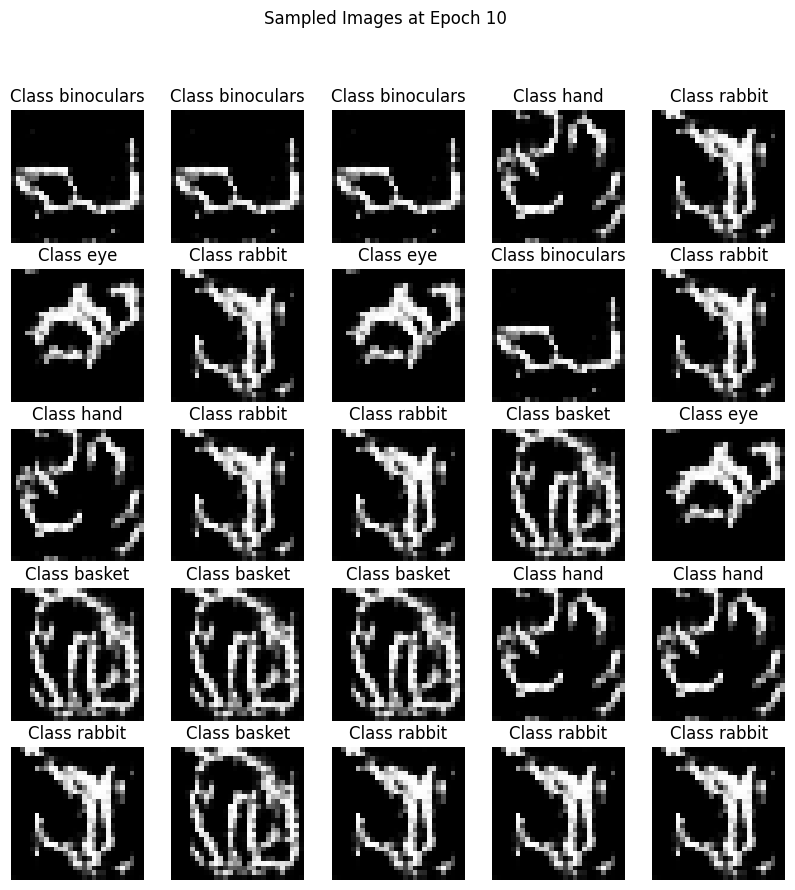

Epoch 11 | Loss_D: 0.0285 | Loss_G: 6.2253
Epoch 12 | Loss_D: 0.0792 | Loss_G: 4.3296
Epoch 13 | Loss_D: 0.7057 | Loss_G: 5.6743
Epoch 14 | Loss_D: 0.0847 | Loss_G: 5.1995
Epoch 15 | Loss_D: 0.1822 | Loss_G: 5.5607
Epoch 16 | Loss_D: 0.0616 | Loss_G: 4.4381
Epoch 17 | Loss_D: 0.2038 | Loss_G: 6.5335
Epoch 18 | Loss_D: 0.0473 | Loss_G: 4.9650
Epoch 19 | Loss_D: 0.0542 | Loss_G: 4.7802
Epoch 20 | Loss_D: 0.0434 | Loss_G: 4.4820


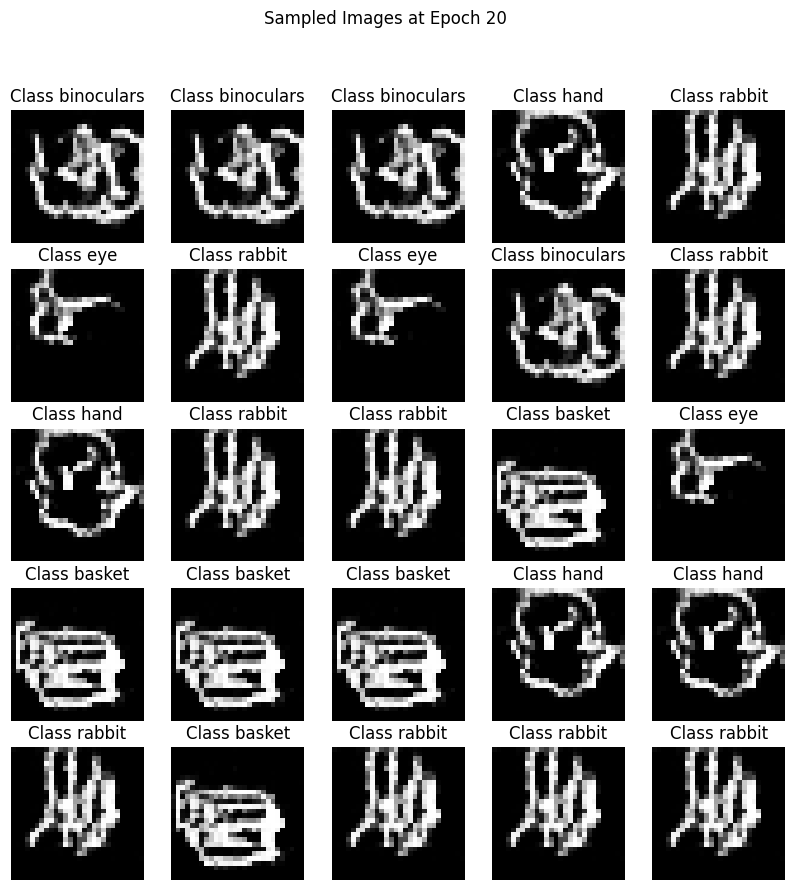

Epoch 21 | Loss_D: 0.0867 | Loss_G: 3.0480
Epoch 22 | Loss_D: 0.0269 | Loss_G: 9.3934
Epoch 23 | Loss_D: 0.0707 | Loss_G: 3.8456
Epoch 24 | Loss_D: 0.0299 | Loss_G: 4.6135
Epoch 25 | Loss_D: 0.1084 | Loss_G: 6.3007
Epoch 26 | Loss_D: 0.0543 | Loss_G: 3.9299


In [ ]:
# GAN Discriminator
class CondDiscriminator(nn.Module):
    def __init__(self, features_d, num_classes, embedding_dim):
        super(CondDiscriminator, self).__init__()

        # Conditional Part: Embedd label and add concat with input
        self.label_embed = nn.Embedding(num_classes, embedding_dim)
        self.label_fc = nn.Linear(embedding_dim, 28 * 28)
        
        self.disc = nn.Sequential(
            nn.Conv2d(
                2, features_d, kernel_size=4, stride=2, padding=1
            ), # 14 x 14
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # 7 x 7
            self._block(features_d*2, features_d*4, 3, 2, 0), # 3 x 3
            nn.Conv2d(features_d*4, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid()
        )


    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False # not needed because of batch norm
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, img, labels):
        label_embedding = self.label_embed(labels)
        label_img = self.label_fc(label_embedding).view(-1, 1, 28, 28)
        x = torch.cat([img, label_img], dim=1)  # concat on channel dim
        return self.disc(x)

# GAN Generator
class CondGenerator(nn.Module):
    def __init__(self, z_dim, features_g, num_classes):
        super(CondGenerator, self).__init__()

        # Conditional Part: Embedd label and add concat with input
        self.label_embed = nn.Embedding(num_classes, z_dim)
        
        self.gen = nn.Sequential(
            self._block(z_dim * 2, features_g*8, 3, 1, 0), # 3 x 3
            self._block(features_g*8, features_g*4, 5, 2, 1), # 7 x 7
            self._block(features_g*4, features_g*2, 4, 2, 1), # 14 x 14
            nn.ConvTranspose2d(features_g*2, 1, kernel_size=4, stride=2, padding=1), # 28 x 28
            nn.Tanh() # [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False # not needed because of batch norm
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embed(labels).unsqueeze(-1).unsqueeze(-1)
        x = torch.cat([noise, label_embedding], dim=1)
        return self.gen(x)


def sample_cgan_images(generator, noise, image_labels, epoch):
    with torch.no_grad():
        generated_images = generator(noise, image_labels) 
        generated_images = generated_images * 0.5 + 0.5  # Unnormalize from [-1, 1] to [0, 1]

    # Plot
    _, axs = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axs.flatten()):
        img = generated_images[i, 0].cpu()

        ax.imshow(img, cmap='gray')
        ax.set_title(classes[image_labels[i].item()])
        ax.axis('off')
        
    plt.suptitle(f'Sampled Images at Epoch {epoch}')
    plt.show()


# DCGAN Dataset and Dataloader
cgan_train_data = QuickDrawDataset('../dataset/train.csv', '../dataset/images', gan_train_transforms)
cgan_train_loader = DataLoader(cgan_train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6, pin_memory=True)

gen = CondGenerator(NOISE_DIM, FEATURES_GEN, 5).to(DEVICE)
disc = CondDiscriminator(FEATURES_DISC, 5, 25).to(DEVICE)

weights_init_normal(gen)
weights_init_normal(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(25, Z_DIM, 1, 1).to(DEVICE)
fixed_labels = tensor = torch.randint(0, 5, (25,), device=DEVICE, dtype=torch.long)

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):

    for idx, (real, real_labels) in enumerate(gan_train_loader):
        real = real.to(DEVICE)
        real_labels = real_labels.to(DEVICE)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(DEVICE)
        fake = gen(noise, real_labels)

        # Train Discriminator
        disc_real = disc(real, real_labels).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake, real_labels).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        # Train Generator
        output = disc(fake, real_labels).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
    
    # Save sample images
    if (epoch + 1) % 5 == 0:
        gen.eval()
        print(f"Epoch {epoch+1}")
        sample_cgan_images(gen, fixed_noise, fixed_labels, epoch+1)
        gen.train()

In [ ]:
LEARNING_RATE = 5e-5
BATCH_SIZE = 128
Z_DIM = 100
NUM_EPOCHS = 50
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

# Dataset and Dataloader
gan_train_data = QuickDrawDataset('../dataset/train.csv', '../dataset/images', gan_train_transforms, class_label=2)
gan_train_loader = DataLoader(gan_train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6, pin_memory=True)

# WGAN Critic
class Critic(nn.Module):
    def __init__(self, features_d):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                1, features_d, kernel_size=4, stride=2, padding=1
            ), # 14 x 14
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # 7 x 7
            self._block(features_d*2, features_d*4, 3, 2, 0), # 3 x 3
            nn.Conv2d(features_d*4, 1, kernel_size=3, stride=1, padding=0),
        )


    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False # not needed because of batch norm
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, img):
        return self.disc(img)

gen = Generator(NOISE_DIM, FEATURES_GEN).to(DEVICE)
critic = Critic(FEATURES_DISC).to(DEVICE)

weights_init_normal(gen)
weights_init_normal(critic)

opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)

fixed_noise = torch.randn(25, Z_DIM, 1, 1).to(DEVICE)

gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):

    for idx, (real, _) in enumerate(gan_train_loader):
        real = real.to(DEVICE)

        # Train Critic
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(DEVICE)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = - (torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train Generator
        output = critic(fake).reshape(-1)
        loss_gen = - torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(f"Epoch {epoch+1} | Loss_D: {loss_critic.item():.4f} | Loss_G: {loss_gen.item():.4f}")
    
    # Save sample images
    if (epoch + 1) % 10 == 0:
        gen.eval()
        sample_gan_images(gen, fixed_noise, epoch+1)
        gen.train()
